In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp 

# Create RDD with Columns required for Solving Queries
RDD7 = sc.textFile("/FileStore/tables/clinicaltrial_2023.csv")

RDD8 = RDD7.map(lambda line: line.replace('"', "").strip(","))
RDD10 = RDD8.map(lambda line: line.split('\t'))

List = RDD10.collect()                     

list_Id = []
list_Type = []
list_Conditions = []
list_Sponsors = []
list_CompletedDates = []

for item in List:
    for index, value in enumerate(item): 
        if index == 0:
            list_Id.append(value)
        elif index == 10:
            list_Type.append(value)
        elif index == 4:
            list_Conditions.append(value)
        elif index == 6:
            list_Sponsors.append(value)
        elif index == 13:
            list_CompletedDates.append(value)
        


#### Create DF for ID column

In [0]:
################################################################
#### Id
Id_Schema = StructType([
    StructField("Index", IntegerType()),
    StructField("Id", StringType())
])

Id_rdd = sc.parallelize(list_Id)
Id_rdd1 = Id_rdd.zipWithIndex()
Id_rdd2 = Id_rdd1.map(lambda values:[values[1], values[0]])

# Data Frame with Id values
Id_DF = spark.createDataFrame(Id_rdd2, Id_Schema)


#### Create DF for Type column 

In [0]:
################################################################
#### Types
Type_Schema = StructType([
    StructField("Index", IntegerType()),
    StructField("Type", StringType())
])

Type_rdd = sc.parallelize(list_Type)
Type_rdd1 = Type_rdd.zipWithIndex()
Type_rdd2 = Type_rdd1.map(lambda values:[values[1], values[0]])

Type_DF = spark.createDataFrame(Type_rdd2, Type_Schema)


#### Create DF for Conditions column 

In [0]:

################################################################
#### Conditions
Conditions_Schema = StructType([
    StructField("Index", IntegerType()),
    StructField("Conditions", StringType())
])

Conditions_rdd = sc.parallelize(list_Conditions)
Conditions_rdd1 = Conditions_rdd.zipWithIndex()
Conditions_rdd2 = Conditions_rdd1.map(lambda values:[values[1], values[0]])

Conditions_DF = spark.createDataFrame(Conditions_rdd2, Conditions_Schema)


#### Create DF for Sponsors column 

In [0]:
################################################################
#### Sponsors
Sponsors_Schema = StructType([
    StructField("Index", IntegerType()),
    StructField("Sponsors", StringType())
])

Sponsors_rdd = sc.parallelize(list_Sponsors)
Sponsors_rdd1 = Sponsors_rdd.zipWithIndex()
Sponsors_rdd2 = Sponsors_rdd1.map(lambda values:[values[1], values[0]])

Sponsors_DF = spark.createDataFrame(Sponsors_rdd2, Sponsors_Schema)


#### Create DF for Completed Dates column 

In [0]:
################################################################
# Completed Dates
CompletedDates_Schema = StructType([
    StructField("Index", IntegerType()),
    StructField("CompletedDates", StringType())
])

CompletedDates_rdd = sc.parallelize(list_CompletedDates)
CompletedDates_rdd.zipWithIndex()
CompletedDates_rdd1 = CompletedDates_rdd.zipWithIndex()
CompletedDates_rdd2 = CompletedDates_rdd1.map(lambda values:[values[1], values[0]])

CompletedDates_DF = spark.createDataFrame(CompletedDates_rdd2,CompletedDates_Schema)


#### Create a combined Dataframe of all extracted columns

In [0]:
################################################################
# Join All Above created DFs
myRDD_DF = Id_DF.join(Type_DF, on='Index', how='inner').join(Conditions_DF, on='Index', how='inner').join(Sponsors_DF, on='Index', how='inner').join(CompletedDates_DF, on='Index', how='inner')

# Ascending Order of Index
myRDD_DF1 = myRDD_DF.orderBy("Index") 

# Remove 1st Row
myRDD_DF2 = myRDD_DF1.filter(myRDD_DF1[0]!="0") 

myRDD_DF2.show(5, truncate=True)

+-----+-----------+--------------+--------------------+--------------------+--------------+
|Index|         Id|          Type|          Conditions|            Sponsors|CompletedDates|
+-----+-----------+--------------+--------------------+--------------------+--------------+
|    1|NCT03630471|INTERVENTIONAL|Mental Health Iss...|             Sangath|    2019-02-28|
|    2|NCT05992571|INTERVENTIONAL|Cerebrovascular F...| McMaster University|       2024-08|
|    3|NCT00237471|INTERVENTIONAL|Myocardial Infarc...|    Melbourne Health|       2006-05|
|    4|NCT03820271|INTERVENTIONAL|Decompensated Cir...|Assistance Publiq...|    2023-10-01|
|    5|NCT06229171|INTERVENTIONAL|Hypertension|Trea...|Istituto Auxologi...|    2026-04-01|
+-----+-----------+--------------+--------------------+--------------------+--------------+
only showing top 5 rows



#### For Clinical Trials 2023
#### Find Number of Distinct Studies in Dataset

In [0]:
DF_ID_Column = myRDD_DF1.select(myRDD_DF1.Id)
#myRDD_DF3.show(5 , truncate = False) # show DataFrame

DF_ID_Column.count()

Out[8]: 483421

#### For Clinical Trials 2023
#### List all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. In order from most frequent to least frequent. 

In [0]:
from pyspark.sql.functions import col

DF_Types_Column = myRDD_DF2.select(myRDD_DF2.Type)

DF_Types_Column1 = DF_Types_Column.groupBy("Type").count().orderBy(col('count').desc())

DF_Types_Column1.show()

+---------------+------+
|           Type| count|
+---------------+------+
| INTERVENTIONAL|371382|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
|               |   889|
+---------------+------+



#### For Clinical Trial 2023
#### The top 5 conditions (from Conditions) with their frequencies. 

In [0]:
from pyspark.sql.functions import *

DF_Conditions_Column = myRDD_DF2.select(myRDD_DF2.Conditions) # Conditions_DF1

DF_Conditions_Column1 = DF_Conditions_Column.withColumn("Conditions", explode(split(col("Conditions"), '\|')))
DF_Conditions_Column2 = DF_Conditions_Column1.groupBy("Conditions").count().orderBy(col('count').desc())
DF_Conditions_Column2.show(5, truncate = False)

+-------------+-----+
|Conditions   |count|
+-------------+-----+
|Healthy      |9731 |
|Breast Cancer|7502 |
|Obesity      |6549 |
|Stroke       |4072 |
|Hypertension |4020 |
+-------------+-----+
only showing top 5 rows



#### For Clinical Trial 2023
#### Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored

In [0]:
from pyspark.sql.functions import *

Pharma_DF = spark.read.csv("/FileStore/tables/pharma.csv", header=True)
#Pharma_DF.show(1, truncate = True)

Pharma_DF1 = Pharma_DF.select("Parent_Company") #.rdd.flatMap(lambda x: x.replace('","','"\t"')).toDF()

Pharma_Names_List = Pharma_DF1.distinct().select("Parent_Company").rdd.flatMap(lambda x: x).collect()


In [0]:
# Get sponsor column from ClinicalTrial Dataset

DF_Sponsors_Column = myRDD_DF2.select(myRDD_DF2.Sponsors)
DF_Sponsors_Column1 = DF_Sponsors_Column.groupBy("Sponsors").count().orderBy(col('count').desc())

# (~) is used to perform filter to check IS NOT IN, opposite of IS IN. 
DF_Sponsors_Column1 = DF_Sponsors_Column1.filter(~col("Sponsors").isin(Pharma_Names_List))

DF_Sponsors_Column1.show(10, truncate = False)


+-------------------------------------------------------------+-----+
|Sponsors                                                     |count|
+-------------------------------------------------------------+-----+
|National Cancer Institute (NCI)                              |3410 |
|Assiut University                                            |3335 |
|Cairo University                                             |3023 |
|Assistance Publique - Hôpitaux de Paris                      |2951 |
|Mayo Clinic                                                  |2766 |
|M.D. Anderson Cancer Center                                  |2702 |
|Novartis Pharmaceuticals                                     |2393 |
|National Institute of Allergy and Infectious Diseases (NIAID)|2340 |
|Massachusetts General Hospital                               |2263 |
|National Taiwan University Hospital                          |2181 |
+-------------------------------------------------------------+-----+
only showing top 10 

#### For Clinical Trial 2023
#### Plot number of completed studies for each month in 2023.

In [0]:
from pyspark.sql.functions import *

DF_CompletedDates = myRDD_DF2.select(myRDD_DF2.CompletedDates)

DF_CompletedDates1 = DF_CompletedDates.groupBy("CompletedDates").count().orderBy(col('count').desc())
DF_CompletedDates2 = DF_CompletedDates1.filter(DF_CompletedDates1[0].like("2023%"))
DF_CompletedDates3 = DF_CompletedDates2.withColumn("Month", month("CompletedDates"))
DF_CompletedDates4 = DF_CompletedDates3.groupBy("Month").sum("count").sort("Month")

DF_CompletedDates4.show()


+-----+----------+
|Month|sum(count)|
+-----+----------+
|    1|      2567|
|    2|      2112|
|    3|      2947|
|    4|      2402|
|    5|      2627|
|    6|      3634|
|    7|      2752|
|    8|      2696|
|    9|      2878|
|   10|      2616|
|   11|      2313|
|   12|      9283|
+-----+----------+



#### Resulted Data Visualization

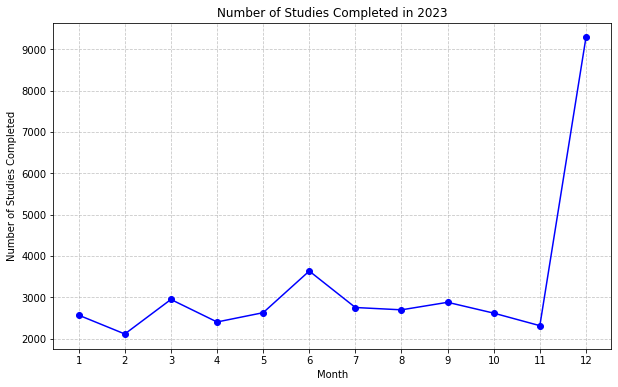

In [0]:
import matplotlib.pyplot as plt

x = DF_CompletedDates4.select('month').rdd.flatMap(lambda x: x).collect()  # Extracting month data
y = DF_CompletedDates4.select('sum(count)').rdd.flatMap(lambda x: x).collect() 

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', color='b', linestyle='-')

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Number of Studies Completed in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Studies Completed')

plt.xticks(x)

plt.show()